In [1]:
import os, time, itertools, sys, io, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import multiprocessing as mp
from copy import deepcopy
from bs4 import BeautifulSoup
from pybaseball import *
sys.path.append('/home/dcooper/rockies/RockiesAnalysis/')
from utils.analysis.home_road_splits import get_day_split_inds
from utils.scraping.safe_playerid_lookup import fangraphs_playerid_lookup
import warnings
warnings.filterwarnings("ignore")

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Get Rockies Hitters' career splits

In [2]:
# Load .csv scraped from BaseballReference
team_df = pd.read_csv('/home/dcooper/rockies/RockiesAnalysis/data/RockiesBatters.csv')

keep_inds = []
for i, r in team_df.iterrows():
    if r['PA'] < 400:
        continue
    if r['To'] < 2015:
        continue
    keep_inds.append(i)
    

team_df = team_df.iloc[keep_inds]
team_df.shape

(47, 29)

In [3]:
# def get_batter_splits(last, first, year):

#     cols = [
#         # Basic info
#         'Season',
#         'Handedness',
    
#         # Counting stats
#         'G',
#         'AB',
#         'PA',
#         'H',
#         '1B',
#         '2B',
#         '3B',
#         'HR',
#         'R',
#         'RBI',
#         'BB',
#         'IBB',
#         'SO',
#         'HBP',
#         'SF',
#         'SH',
#         'GIDP',
#         'SB',
#         'CS',
    
#         # Rate stats (traditional)
#         'AVG',
    
#         # Duplicate section header (drop or keep once)
#         'Season_2',
#         'Handedness_2',
    
#         # Plate discipline & advanced rates
#         'BB_pct',
#         'K_pct',
#         'BB_to_K',
#         'AVG_2',
#         'OBP',
#         'SLG',
#         'OPS',
#         'ISO',
#         'BABIP',
#         'wRC',
#         'wRAA',
#         'wOBA',
#         'wRC_plus',
    
#         # Duplicate section header (drop or keep once)
#         'Season_3',
#         'Handedness_3',
    
#         # Batted-ball profile
#         'GB_to_FB',
#         'LD_pct',
#         'GB_pct',
#         'FB_pct',
#         'IFFB_pct',
#         'HR_to_FB',
#         'IFH_pct',
#         'BUH_pct',
    
#         # Divider (usually drop)
#         'divider',
    
#         # Spray angles
#         'Pull_pct',
#         'Cent_pct',
#         'Oppo_pct',
    
#         # Divider
#         'divider_1',
    
#         # Contact quality (BIS)
#         'Soft_pct',
#         'Med_pct',
#         'Hard_pct',
    
#         # Divider
#         'divider_2',
    
#         # Pitch-level
#         'Pitches',
#         'Balls',
#         'Strikes'
#     ]
    
#     drop_inds = [cols[i] for i in [22,23,37,38,47,51,55]] # Removes extra columns

    
#     # Look up playerid
#     playerid = fangraphs_playerid_lookup(last, first)
        
#     # Scrape FanGraphs
#     URL = f'https://www.fangraphs.com/players/{last}-{first}/{playerid}/splits?position=NP&season={year}&split='
#     session = requests.session()
#     content = session.get(URL).content
#     soup = BeautifulSoup(content)
#     tables = soup.find_all('table')

#     try:
#         df1 = pd.read_html(io.StringIO(str(tables[8])))[0] # Standard
#         df1 = df1.loc[df1['Handedness'].isin(['Home', 'Away'])]
        
#     except:
#         print(URL)
#         for i, table in enumerate(tables):
#             print(i, table.get_text(strip=True)[:300])
#         raise Exception()
#     df2 = pd.read_html(io.StringIO(str(tables[10])))[0] # Advanced
#     df2 = df2.loc[df2['Handedness'].isin(['Home', 'Away'])]
#     df3 = pd.read_html(io.StringIO(str(tables[12])))[0] # Batted Ball
#     df3 = df3.loc[df3['Handedness'].isin(['Home', 'Away'])]
#     df = pd.concat([df1, df2, df3], axis=1)
#     df.columns = cols
#     df = df.drop(columns=drop_inds)
#     df.insert(0, 'Name', [f'{first} {last}', f'{first} {last}'])

#     # Remove percent symbols
#     for i, col in enumerate(df.columns):
#         if type(df[col].to_numpy()[0]) == str and '%' in df[col].to_numpy()[0]:
#             df[col] = df[col].str.replace('%', '', regex=False).astype(float)
    
#     return df

# def combine_split_years(year_dfs):

#     sum_inds = np.array([3,4,5,6,7,8,9,10,11,12,12,13,14,15,16,17,18,19,20,21,32,33,50,51,52])
#     AB_inds = np.array([22,26,28,30,31])
#     PA_inds = np.array([23,24,25,27,29,34,35])
#     BIP_inds = np.array([31,36,37,38,39,40,41,42,43,44,45,46,47,48,49])
#     drop_inds = np.array([0,1,2])

#     # Build new df
#     name = year_dfs[0]['Name'].to_list()[0]
#     total_df = pd.DataFrame(index=pd.MultiIndex.from_product([[name], ['Home', 'Away']]), columns=year_dfs[0].columns.to_list()[3:])

#     # Combine
#     for i, col in enumerate(year_dfs[0].columns):
#         if i < 3:
#             continue

#         # Sum
#         if i in sum_inds:
#             home_val = 0
#             away_val = 0
#             for year_df in year_dfs:
#                 home_val += year_df.loc[year_df['Handedness'] == 'Home', col].to_numpy().astype(float)[0]
#                 away_val += year_df.loc[year_df['Handedness'] == 'Away', col].to_numpy().astype(float)[0]
                
#         # Dot products
#         else:
#             home_counts = np.zeros(len(year_dfs))
#             home_vals = np.zeros(len(year_dfs))
#             away_counts = np.zeros(len(year_dfs))
#             away_vals = np.zeros(len(year_dfs))
#             for j, year_df in enumerate(year_dfs):
#                 home_vals[j] = year_df.loc[year_df['Handedness'] == 'Home', col].to_numpy().astype(float)[0]
#                 away_vals[j] = year_df.loc[year_df['Handedness'] == 'Away', col].to_numpy().astype(float)[0]
    
#                 if i in AB_inds:
#                     home_counts[j] = year_df.loc[year_df['Handedness'] == 'Home', 'AB'].to_numpy().astype(float)[0]
#                     away_counts[j] = year_df.loc[year_df['Handedness'] == 'Away', 'AB'].to_numpy().astype(float)[0]
                    
#                 elif i in PA_inds:
#                     home_counts[j] = year_df.loc[year_df['Handedness'] == 'Home', 'PA'].to_numpy().astype(float)[0]
#                     away_counts[j] = year_df.loc[year_df['Handedness'] == 'Away', 'PA'].to_numpy().astype(float)[0]
                    
#                 elif i in BIP_inds:
#                     home_PA = year_df.loc[year_df['Handedness'] == 'Home', 'PA'].to_numpy().astype(float)[0]
#                     home_SO = year_df.loc[year_df['Handedness'] == 'Home', 'SO'].to_numpy().astype(float)[0]
#                     home_BB = year_df.loc[year_df['Handedness'] == 'Home', 'BB'].to_numpy().astype(float)[0]
#                     home_HBP = year_df.loc[year_df['Handedness'] == 'Home', 'HBP'].to_numpy().astype(float)[0]
#                     home_counts[j] = home_PA - home_SO - home_BB - home_HBP
    
#                     away_PA = year_df.loc[year_df['Handedness'] == 'Away', 'PA'].to_numpy().astype(float)[0]
#                     away_SO = year_df.loc[year_df['Handedness'] == 'Away', 'SO'].to_numpy().astype(float)[0]
#                     away_BB = year_df.loc[year_df['Handedness'] == 'Away', 'BB'].to_numpy().astype(float)[0]
#                     away_HBP = year_df.loc[year_df['Handedness'] == 'Away', 'HBP'].to_numpy().astype(float)[0]
#                     away_counts[j] = away_PA - away_SO - away_BB - away_HBP

#             home_val = np.dot(home_counts / home_counts.sum(), home_vals)
#             away_val = np.dot(away_counts / away_counts.sum(), away_vals)

#         # Add to new dataframe
#         total_df.loc[(name, 'Home'), col] = home_val
#         total_df.loc[(name, 'Away'), col] = away_val


#     return total_df


In [4]:
# Example for columns
from utils.analysis.home_road_splits import get_batter_splits, combine_split_years
example_df = get_batter_splits('Goodman', 'Hunter', 2025)

# Iterate through players
cols = ['G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GIDP', 'SB', 'CS', 'AVG', 'BB_pct', 'K_pct', 'BB_to_K', 'AVG_2', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC_plus', 'GB_to_FB', 'LD_pct', 'GB_pct', 'FB_pct', 'IFFB_pct', 'HR_to_FB', 'IFH_pct', 'BUH_pct', 'Pull_pct', 'Cent_pct', 'Oppo_pct', 'Soft_pct', 'Med_pct', 'Hard_pct', 'Pitches', 'Balls', 'Strikes']
player_splits_df = pd.DataFrame(index=pd.MultiIndex.from_product([team_df['Name'].to_list(), ['Home', 'Away']]), columns=cols)
for i, (name, start_year, end_year) in enumerate(zip(team_df['Name'].to_list(), team_df['From'].to_list(), team_df['To'].to_list())):

    first, last = name.split()
    if first == 'C.J.':
        first = 'CJ'

    # Get each year
    player_years_dfs = []
    for year in range(start_year, end_year+1):
        print(first, last, year)
        if last == 'Dahl' and year == 2017:
            continue
        if last == 'Daza' and year == 2020:
            continue
        player_years_dfs.append(get_batter_splits(last, first, year))

    # Combine years
    player_totals_df = combine_split_years(player_years_dfs)
    player_splits_df.loc[(name, 'Home')] = player_totals_df.iloc[0]
    player_splits_df.loc[(name, 'Away')] = player_totals_df.iloc[1]

    

player_splits_df.head()

Gathering player lookup table. This may take a moment.
Nolan Arenado 2013
Nolan Arenado 2014
Nolan Arenado 2015
Nolan Arenado 2016
Nolan Arenado 2017
Nolan Arenado 2018
Nolan Arenado 2019
Nolan Arenado 2020
Brandon Barnes 2014
Brandon Barnes 2015
Brandon Barnes 2016
Jordan Beck 2024
Jordan Beck 2025
Charlie Blackmon 2011
Charlie Blackmon 2012
Charlie Blackmon 2013
Charlie Blackmon 2014
Charlie Blackmon 2015
Charlie Blackmon 2016
Charlie Blackmon 2017
Charlie Blackmon 2018
Charlie Blackmon 2019
Charlie Blackmon 2020
Charlie Blackmon 2021
Charlie Blackmon 2022
Charlie Blackmon 2023
Charlie Blackmon 2024
Kris Bryant 2022
Kris Bryant 2023
Kris Bryant 2024
Kris Bryant 2025
CJ Cron 2021
CJ Cron 2022
CJ Cron 2023
David Dahl 2016
David Dahl 2017
David Dahl 2018
David Dahl 2019
David Dahl 2020
Yonathan Daza 2019
Yonathan Daza 2020
Yonathan Daza 2021
Yonathan Daza 2022
Yonathan Daza 2023
Daniel Descalso 2015
Daniel Descalso 2016
Ian Desmond 2017
Ian Desmond 2018
Ian Desmond 2019
Elias Díaz 2020


G      AB      PA      H     1B     2B    3B     HR  \
Nolan Arenado  Home  543.0  2080.0  2303.0  669.0  364.0  148.0  21.0  136.0   
               Away  534.0  2038.0  2255.0  537.0  318.0  114.0   6.0   99.0   
Brandon Barnes Home  140.0   327.0   360.0   95.0   60.0   21.0   6.0    8.0   
               Away  131.0   320.0   343.0   66.0   47.0   15.0   2.0    2.0   
Jordan Beck    Home  101.0   368.0   397.0  105.0   72.0   22.0   3.0    8.0   

                         R    RBI  ...    BUH_pct   Pull_pct   Cent_pct  \
Nolan Arenado  Home  386.0  461.0  ...        0.0  40.527542  36.271453   
               Away  263.0  299.0  ...  20.147059  43.184529  33.824882   
Brandon Barnes Home   53.0   38.0  ...   14.09879  39.920565  36.672984   
               Away   24.0   14.0  ...  26.697674  25.080465  38.142791   
Jordan Beck    Home   48.0   39.0  ...  40.114068  41.073004  35.345627   

                      Oppo_pct   Soft_pct    Med_pct   Hard_pct Pitches  \
Nolan Arenado  Home  23.186704  14.202737  46.407095  39.416369  8344.0   
               Away  22.994706  17.415647  47.888412  34.694353  8446.0   
Brandon Barnes Home  23.383468  12.095968  56.025806  31.878226  1297.0   
               Away  36.764186  22.766512   54.43907   22.78186  1277.0   
Jordan Beck    Home  23.581369  15.241445  46.391635   38.36692  1466.0   

                      Balls Strikes  
Nolan Arenado  Home  3029.0  5315.0  
               Away  2984.0  5462.0  
Brandon Barnes Home   398.0   899.0  
               Away   402.0   875.0  
Jordan Beck    Home   506.0   960.0  

[5 rows x 50 columns]

## Init diffs_df

In [74]:
# Build dataframe
player_names = np.array([n[0] for n in player_splits_df.index][::2])
diffs_df = pd.DataFrame(columns=['ΔwRC+', 'ΔwOBA', 'ΔuBB', 'ΔHBP', 'Δ1B', 'Δ2B', 'Δ3B', 'ΔHR', 'ΔSO', \
                                 'home_wRC+', 'home_wOBA', 'home_uBB', 'home_HBP', 'home_1B', 'home_2B', 'home_3B', 'home_HR', \
                                 'away_wRC+', 'away_wOBA', 'away_uBB', 'away_HBP', 'away_1B', 'away_2B', 'away_3B', 'away_HR'], index=player_names)

## Plot wRC+ splits

In [75]:
# Get wRC+ difference to sort for plot
wRC_plus_differences = player_splits_df['wRC_plus'].to_numpy().astype(float)[::2] - (100 + (player_splits_df['wRC_plus'].to_numpy().astype(float)[1::2] - 100) / 1.13)
sorted_player_names = player_names[np.argsort(wRC_plus_differences)]
sorted_player_last_years = team_df['To'].to_numpy().astype(int)[np.argsort(wRC_plus_differences)]

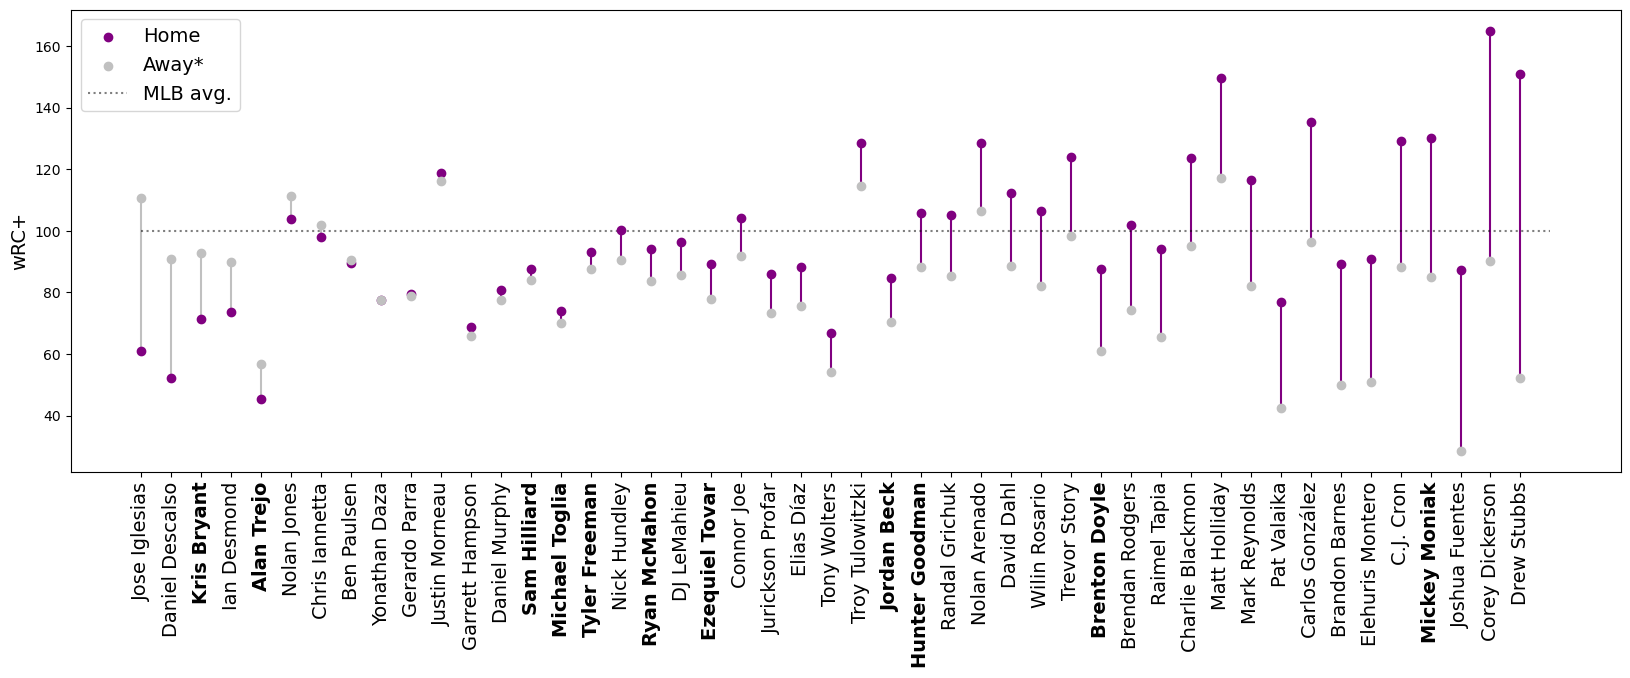

In [76]:
# Plot wRC+ discrepancies
fig, ax = plt.subplots(figsize=(20, 6))
for x, (name) in enumerate(sorted_player_names):

    # Recalculate PF for wRC+
    home_wRC_plus = float(player_splits_df.loc[(name,'Home')]['wRC_plus'])
    away_wRC_plus = 100 + (float(player_splits_df.loc[(name,'Away')]['wRC_plus']) - 100) / 1.13
    diffs_df.loc[name]['ΔwRC+'] = home_wRC_plus - away_wRC_plus
    diffs_df.loc[name]['home_wRC+'] = home_wRC_plus
    diffs_df.loc[name]['away_wRC+'] = away_wRC_plus
    
    # Plot connecting line
    if away_wRC_plus > home_wRC_plus:
        color = 'silver'
    else:
        color = 'purple'
    ax.vlines(x, away_wRC_plus, home_wRC_plus, color=color, zorder=1)

    # Plot
    if x == 0:
        home_label = 'Home'
        away_label = 'Away*'
    else:
        home_label = None
        away_label = None
    ax.scatter(x, home_wRC_plus, color='purple', zorder=10, label=home_label)
    ax.scatter(x, away_wRC_plus, color='silver', zorder=10, label=away_label)

ax.set_xticks(np.arange(0, player_splits_df.shape[0]/2), sorted_player_names, rotation=90, fontsize=14)
for (label, last_year) in zip(ax.get_xticklabels(), sorted_player_last_years):
    if last_year == 2025:
        label.set_fontweight('bold')
ax.hlines(100, 0, player_splits_df.shape[0]/2, color='k', linestyle='dotted', alpha=0.50, label='MLB avg.')
ax.set_ylabel('wRC+', fontsize=14)
ax.legend(loc='upper left', fontsize=14)
plt.show()

## Plot wOBA splits

In [77]:
# Get wOBA difference to sort for plot
wOBA_differences = player_splits_df['wOBA'].to_numpy().astype(float)[::2] - player_splits_df['wOBA'].to_numpy().astype(float)[1::2]
player_names = np.array([n[0] for n in player_splits_df.index][::2])
sorted_player_names = player_names[np.argsort(wOBA_differences)]
sorted_player_last_years = team_df['To'].to_numpy().astype(int)[np.argsort(wOBA_differences)]

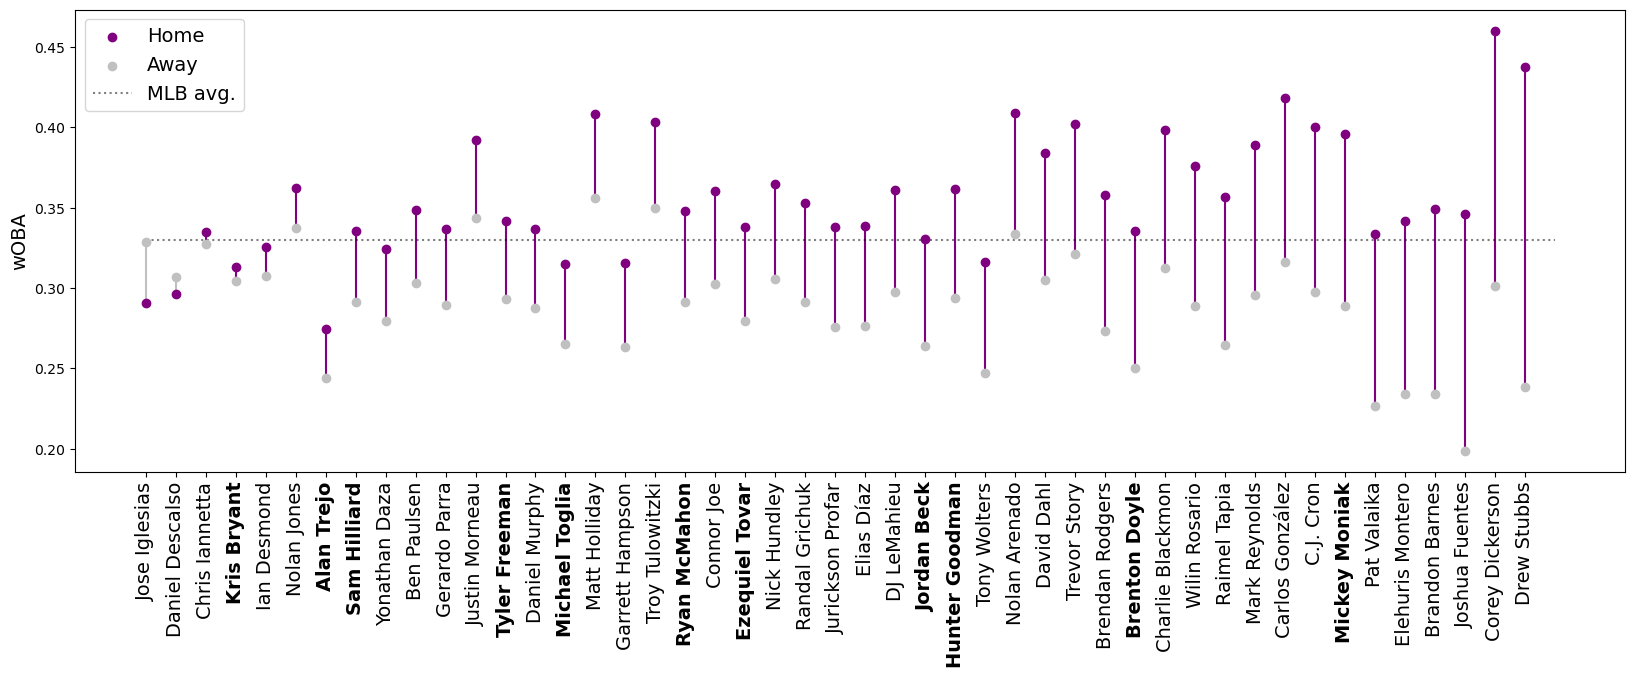

In [78]:
# Plot wOBA discrepancies
fig, ax = plt.subplots(figsize=(20, 6))
for x, (name) in enumerate(sorted_player_names):

    # Recalculate PF for wRC+
    home_wOBA = float(player_splits_df.loc[(name,'Home')]['wOBA'])
    away_wOBA = float(player_splits_df.loc[(name,'Away')]['wOBA'])
    diffs_df.loc[name]['ΔwOBA'] = home_wOBA - away_wOBA
    diffs_df.loc[name]['home_wOBA'] = home_wOBA
    diffs_df.loc[name]['away_wOBA'] = away_wOBA
    
    # Plot connecting line
    if away_wOBA > home_wOBA:
        color = 'silver'
    else:
        color = 'purple'
    ax.vlines(x, away_wOBA, home_wOBA, color=color, zorder=1)

    # Plot
    if x == 0:
        home_label = 'Home'
        away_label = 'Away'
    else:
        home_label = None
        away_label = None
    ax.scatter(x, home_wOBA, color='purple', zorder=10, label=home_label)
    ax.scatter(x, away_wOBA, color='silver', zorder=10, label=away_label)

ax.set_xticks(np.arange(0, player_splits_df.shape[0]/2), sorted_player_names, rotation=90, fontsize=14)
for (label, last_year) in zip(ax.get_xticklabels(), sorted_player_last_years):
    if last_year == 2025:
        label.set_fontweight('bold')
ax.hlines(0.330, 0, player_splits_df.shape[0]/2, color='k', linestyle='dotted', alpha=0.50, label='MLB avg.')
ax.set_ylabel('wOBA', fontsize=14)
ax.legend(loc='upper left', fontsize=14)
plt.show()

## Decompose wOBA splits

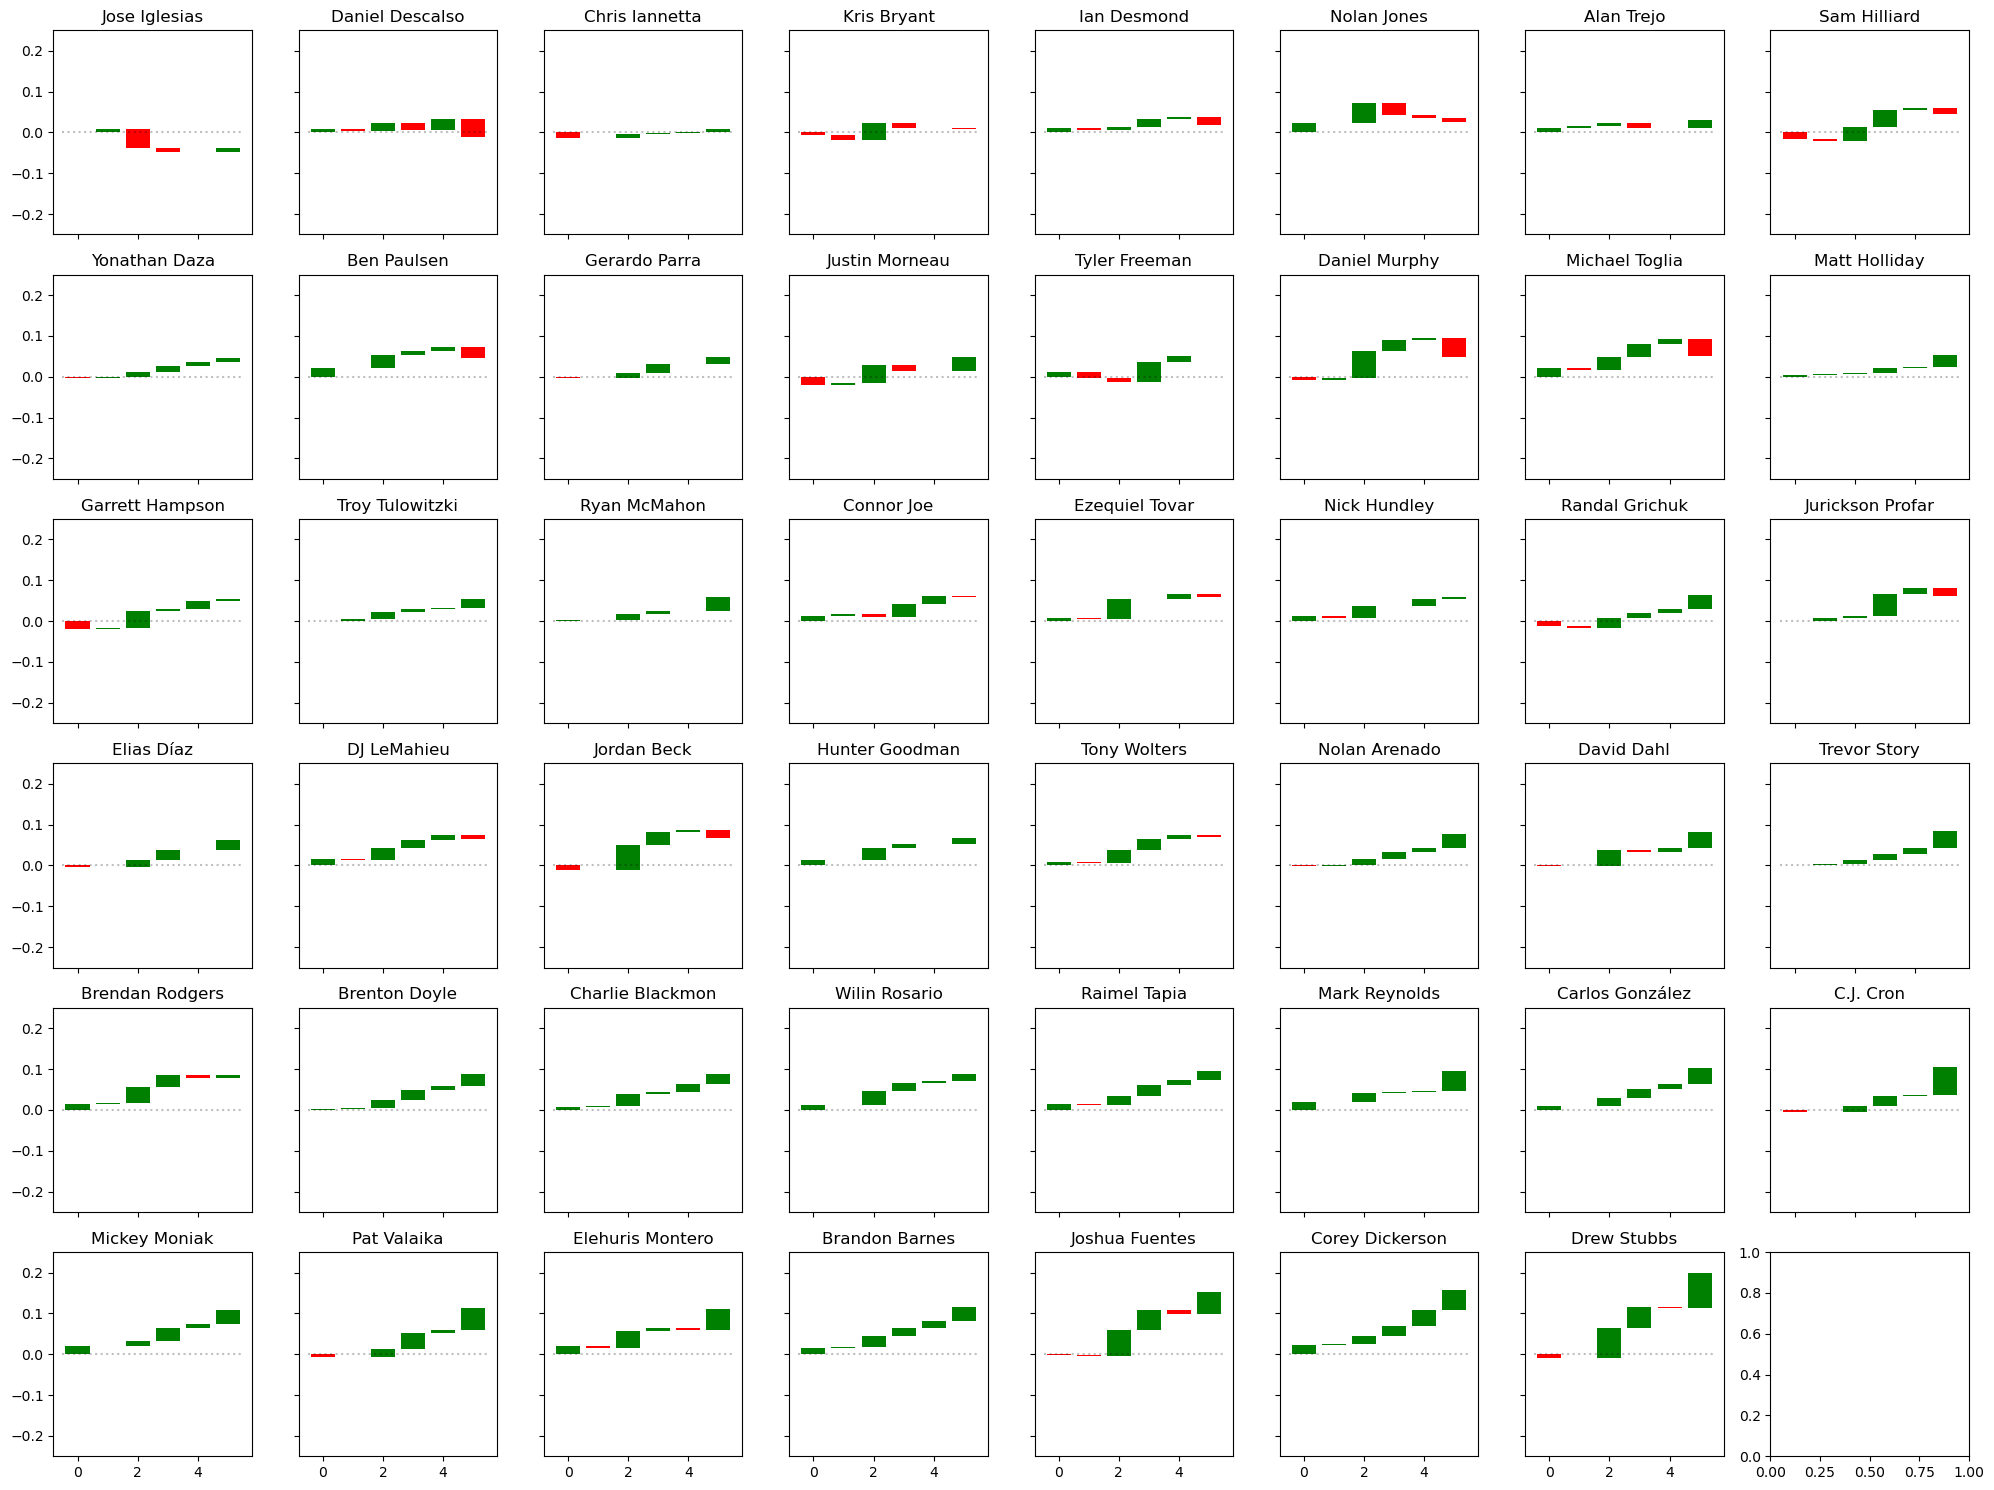

In [79]:
## Decompose wOBA splits

# Simple method to choose waterfall color
def choose_color(diff):
    if diff > 0:
        return 'green'
    else:
        return 'red'

cmap = plt.get_cmap('twilight_shifted')
colors = cmap(np.linspace(0, 1, 7))
fig, axs = plt.subplots(6,8, figsize=(20,15))
for i, (name, ax) in enumerate(zip(sorted_player_names, axs.flatten())):

    # Get player home numbers
    home_uBB = int(player_splits_df.loc[(name, 'Home')]['BB']) - int(player_splits_df.loc[(name, 'Home')]['IBB'])
    home_HBP = int(player_splits_df.loc[(name, 'Home')]['HBP'])
    home_singles = int(player_splits_df.loc[(name, 'Home')]['1B'])
    home_doubles = int(player_splits_df.loc[(name, 'Home')]['2B'])
    home_triples = int(player_splits_df.loc[(name, 'Home')]['3B'])
    home_home_runs = int(player_splits_df.loc[(name, 'Home')]['HR'])
    home_strike_outs = int(player_splits_df.loc[(name, 'Home')]['SO'])
    home_denom = int(player_splits_df.loc[(name, 'Home')]['AB']) + home_uBB + int(player_splits_df.loc[(name, 'Home')]['SF']) + home_HBP
    diffs_df.loc[name]['home_uBB'] = 0.69 * (home_uBB/home_denom)
    diffs_df.loc[name]['home_HBP'] = 0.72 * (home_HBP/home_denom)
    diffs_df.loc[name]['home_1B'] = 0.89 * (home_singles/home_denom)
    diffs_df.loc[name]['home_2B'] = 1.27 * (home_doubles/home_denom)
    diffs_df.loc[name]['home_3B'] = 1.62 * (home_triples/home_denom)
    diffs_df.loc[name]['home_HR'] = 2.10 * (home_home_runs/home_denom)
    diffs_df.loc[name]['home_SO'] = 1 * (home_strike_outs/home_denom)
    
    # Get player away numbers
    away_uBB = int(player_splits_df.loc[(name, 'Away')]['BB']) - int(player_splits_df.loc[(name, 'Away')]['IBB'])
    away_HBP = int(player_splits_df.loc[(name, 'Away')]['HBP'])
    away_singles = int(player_splits_df.loc[(name, 'Away')]['1B'])
    away_doubles = int(player_splits_df.loc[(name, 'Away')]['2B'])
    away_triples = int(player_splits_df.loc[(name, 'Away')]['3B'])
    away_home_runs = int(player_splits_df.loc[(name, 'Away')]['HR'])
    away_strike_outs = int(player_splits_df.loc[(name, 'Away')]['SO'])
    away_denom = int(player_splits_df.loc[(name, 'Away')]['AB']) + away_uBB + int(player_splits_df.loc[(name, 'Away')]['SF']) + away_HBP
    diffs_df.loc[name]['away_uBB'] = 0.69 * (away_uBB/away_denom)
    diffs_df.loc[name]['away_HBP'] = 0.72 * (away_HBP/away_denom)
    diffs_df.loc[name]['away_1B'] = 0.89 * (away_singles/away_denom)
    diffs_df.loc[name]['away_2B'] = 1.27 * (away_doubles/away_denom)
    diffs_df.loc[name]['away_3B'] = 1.62 * (away_triples/away_denom)
    diffs_df.loc[name]['away_HR'] = 2.10 * (away_home_runs/away_denom)
    diffs_df.loc[name]['away_SO'] = 1 * (away_strike_outs/away_denom)

    
    # Get weighted differences
    diff_uBB = 0.69 * ((home_uBB/home_denom) - (away_uBB/away_denom))
    diff_HBP = 0.72 * ((home_HBP/home_denom) - (away_HBP/away_denom))
    diff_singles = 0.89 * ((home_singles/home_denom) - (away_singles/away_denom))
    diff_doubles = 1.27 * ((home_doubles/home_denom) - (away_doubles/away_denom))
    diff_triples = 1.62 * ((home_triples/home_denom) - (away_triples/away_denom))
    diff_home_runs = 2.10 * ((home_home_runs/home_denom) - (away_home_runs/away_denom))
    diff_strike_outs = 1 * ((home_strike_outs/home_denom) - (away_strike_outs/away_denom))
    diff_wOBA = np.array([diff_uBB, diff_HBP, diff_singles, diff_doubles, diff_triples, diff_home_runs]).sum()

    # Save to df
    diffs_df.loc[name]['ΔuBB'] = diff_uBB
    diffs_df.loc[name]['ΔHBP'] = diff_HBP
    diffs_df.loc[name]['Δ1B'] = diff_singles
    diffs_df.loc[name]['Δ2B'] = diff_doubles
    diffs_df.loc[name]['Δ3B'] = diff_triples
    diffs_df.loc[name]['ΔHR'] = diff_home_runs
    diffs_df.loc[name]['ΔSO'] = diff_strike_outs

    # Waterfall chart
    y = 0
    color = choose_color(diff_uBB)
    ax.bar(0, diff_uBB, bottom=y, color=color)
    y += diff_uBB
    color = choose_color(diff_HBP)
    ax.bar(1, diff_HBP, bottom=y, color=color)
    y += diff_HBP
    color = choose_color(diff_singles)
    ax.bar(2, diff_singles, bottom=y, color=color)
    y += diff_singles
    color = choose_color(diff_doubles)
    ax.bar(3, diff_doubles, bottom=y, color=color)
    y += diff_doubles
    color = choose_color(diff_triples)
    ax.bar(4, diff_triples, bottom=y, color=color)
    y += diff_triples
    color = choose_color(diff_home_runs)
    ax.bar(5, diff_home_runs, bottom=y, color=color)

    ax.set_title(name)
    ax.set_ylim(-0.25, 0.25)
    ax.hlines(0, -0.5, 5.5, color='k', linestyle='dotted', alpha=0.25)
    ax.label_outer()
    

fig.tight_layout()
plt.show()    



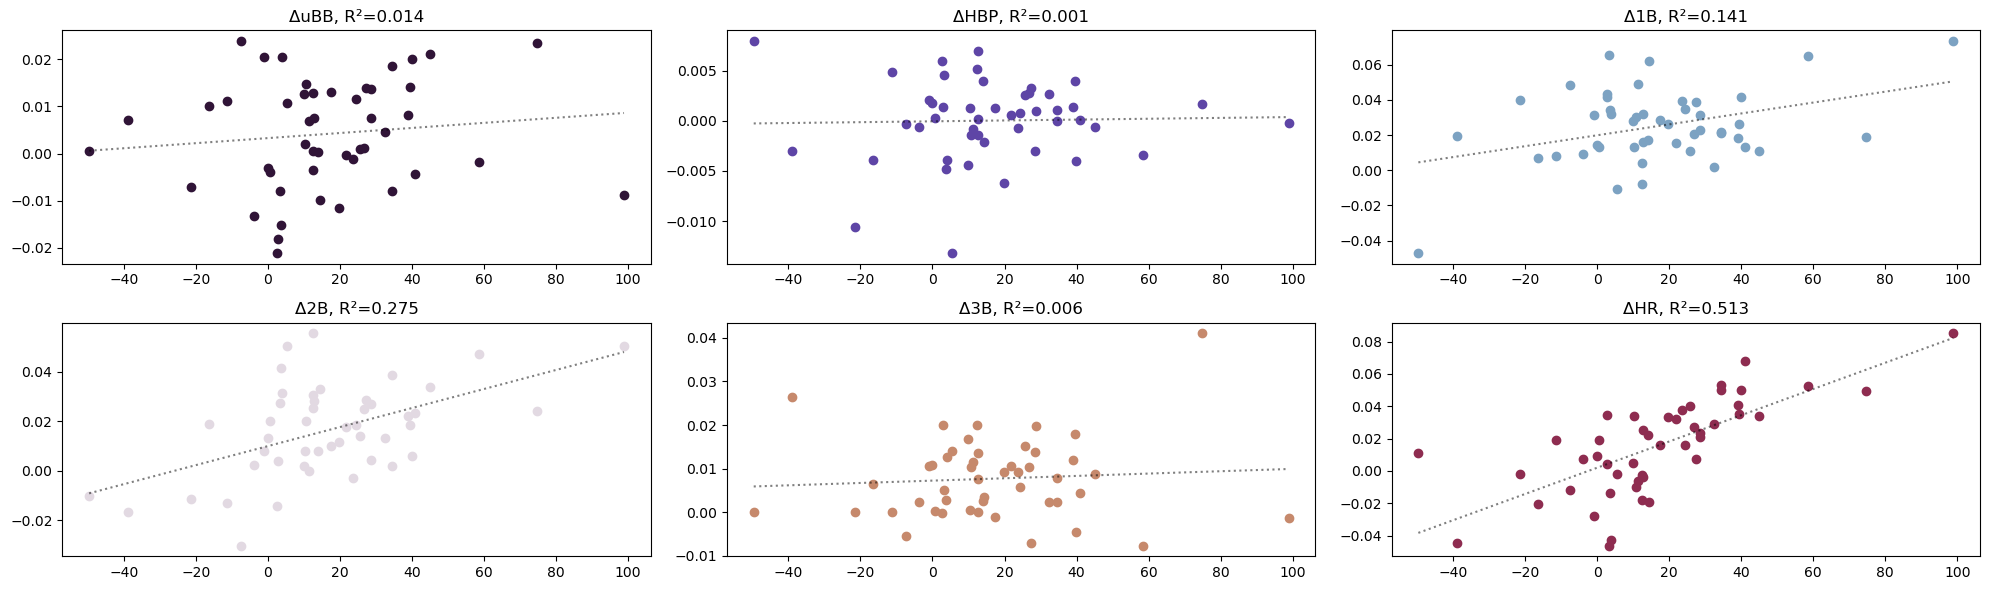

In [80]:
## Decompose wOBA splits
wOBA_decom_differences = np.zeros((len(sorted_player_names), 6))
fig, axs = plt.subplots(2,3,figsize=(20, 6))
for x, (name) in enumerate(sorted_player_names):
   
    # Plot
    alpha = 1
    marker = 'o'
    axs[0,0].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['ΔuBB'], color=colors[0], marker=marker, alpha=alpha)
    axs[0,1].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['ΔHBP'], color=colors[1], marker=marker, alpha=alpha)
    axs[0,2].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['Δ1B'], color=colors[2], marker=marker, alpha=alpha)
    axs[1,0].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['Δ2B'], color=colors[3], marker=marker, alpha=alpha)
    axs[1,1].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['Δ3B'], color=colors[4], marker=marker, alpha=alpha)
    axs[1,2].scatter(diffs_df.loc[name]['ΔwRC+'], diffs_df.loc[name]['ΔHR'], color=colors[5], marker=marker, alpha=alpha)

from scipy.stats import linregress
diffs_df = diffs_df.astype(float)
titles = ['ΔuBB', 'ΔHBP', 'Δ1B', 'Δ2B', 'Δ3B', 'ΔHR']
for i, (title, ax) in enumerate(zip(titles, axs.flatten())):
    m, b, r, _, _ = linregress(diffs_df['ΔwRC+'].to_numpy(), diffs_df[title].to_numpy())
    xs = np.linspace(diffs_df['ΔwRC+'].to_numpy().min(), diffs_df['ΔwRC+'].to_numpy().max(), 100)
    ax.plot(xs, m*xs + b, color='k', linestyle='dotted', alpha=0.5)
    ax.set_title(f'{title}, R\u00B2={r**2:.3f}')

fig.tight_layout()
plt.show()

## Create categories

In [81]:
diffs_df.head()

,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,home_3B,home_HR,away_wRC+,away_wOBA,away_uBB,away_HBP,away_1B,away_2B,away_3B,away_HR
Nolan Arenado,21.792415,0.074799,-0.000341,0.000569,0.015456,0.017703,0.010616,0.032335,-0.026261,128.379939,...,0.014987,0.125815,106.587524,0.333914,0.046848,0.003237,0.127257,0.065099,0.004371,0.093480
Brandon Barnes,39.470575,0.114640,0.014167,0.003970,0.026409,0.018687,0.017864,0.035055,-0.093535,89.322222,...,0.027535,0.047592,49.851647,0.234443,0.028836,0.002149,0.124866,0.056866,0.009672,0.012537
Jordan Beck,14.395760,0.066606,-0.009942,-0.002139,0.061872,0.033203,0.003610,-0.019340,-0.087938,84.717884,...,0.012273,0.042424,70.322124,0.263971,0.053503,0.005775,0.099947,0.037353,0.008663,0.061765
Charlie Blackmon,28.670357,0.085868,0.007457,0.000994,0.031516,0.004488,0.019726,0.023753,-0.040173,123.703414,...,0.026030,0.082209,95.033058,0.312737,0.042131,0.011206,0.138788,0.060440,0.006304,0.058456
Kris Bryant,-21.415570,0.008246,-0.007069,-0.010605,0.039751,-0.011480,0.000000,-0.001717,-0.044728,71.475196,...,0.000000,0.049347,92.890766,0.304626,0.062918,0.021884,0.113617,0.057903,0.000000,0.051064


In [82]:
# Assign players to categories
wRC_plus_third = np.percentile(np.abs(diffs_df['ΔwRC+']), 33)
wRC_plus_two_thirds = np.percentile(np.abs(diffs_df['ΔwRC+']), 67)
diffs_df['category'] = np.zeros(diffs_df.shape[0], dtype=str)
for i, (home_wRC_plus, away_wRC_plus, wRC_plus_split) in enumerate(zip(diffs_df['home_wRC+'].to_list(), diffs_df['away_wRC+'].to_list(), diffs_df['ΔwRC+'].to_list())):

    # Check home for near average
    if home_wRC_plus < 90:
        home_average_comp = 'below'
    elif home_wRC_plus <= 110:
        home_average_comp = 'avg'
    else:
        home_average_comp = 'above'

    # Check away for near average
    if away_wRC_plus < 90:
        away_average_comp = 'below'
    elif away_wRC_plus <= 110:
        away_average_comp = 'avg'
    else:
        away_average_comp = 'above'

    # Check split size
    if np.abs(wRC_plus_split) < wRC_plus_third:
        split_size = 'small'
    elif np.abs(wRC_plus_split) <= wRC_plus_two_thirds:
        split_size = 'med'
    else:
        split_size = 'large'

    # Check for inverse
    if wRC_plus_split < 0:
        is_inverse = '_inverse'
    else:
        is_inverse = ''

    # Add to df 
    # diffs_df['category'].iloc[i] = f'{home_average_comp}_{away_average_comp}_{split_size}' + is_inverse
    diffs_df['category'].iloc[i] = f'{split_size}' + is_inverse


diffs_df.head()

,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,home_HR,away_wRC+,away_wOBA,away_uBB,away_HBP,away_1B,away_2B,away_3B,away_HR,category
Nolan Arenado,21.792415,0.074799,-0.000341,0.000569,0.015456,0.017703,0.010616,0.032335,-0.026261,128.379939,...,0.125815,106.587524,0.333914,0.046848,0.003237,0.127257,0.065099,0.004371,0.093480,med
Brandon Barnes,39.470575,0.114640,0.014167,0.003970,0.026409,0.018687,0.017864,0.035055,-0.093535,89.322222,...,0.047592,49.851647,0.234443,0.028836,0.002149,0.124866,0.056866,0.009672,0.012537,large
Jordan Beck,14.395760,0.066606,-0.009942,-0.002139,0.061872,0.033203,0.003610,-0.019340,-0.087938,84.717884,...,0.042424,70.322124,0.263971,0.053503,0.005775,0.099947,0.037353,0.008663,0.061765,med
Charlie Blackmon,28.670357,0.085868,0.007457,0.000994,0.031516,0.004488,0.019726,0.023753,-0.040173,123.703414,...,0.082209,95.033058,0.312737,0.042131,0.011206,0.138788,0.060440,0.006304,0.058456,large
Kris Bryant,-21.415570,0.008246,-0.007069,-0.010605,0.039751,-0.011480,0.000000,-0.001717,-0.044728,71.475196,...,0.049347,92.890766,0.304626,0.062918,0.021884,0.113617,0.057903,0.000000,0.051064,med_inverse


## Simple decision tree

In [83]:
diffs_df.columns

Index(['ΔwRC+', 'ΔwOBA', 'ΔuBB', 'ΔHBP', 'Δ1B', 'Δ2B', 'Δ3B', 'ΔHR', 'ΔSO',
       'home_wRC+', 'home_wOBA', 'home_uBB', 'home_HBP', 'home_1B', 'home_2B',
       'home_3B', 'home_HR', 'away_wRC+', 'away_wOBA', 'away_uBB', 'away_HBP',
       'away_1B', 'away_2B', 'away_3B', 'away_HR', 'category'],
      dtype='object')

Accuracy: 0.894


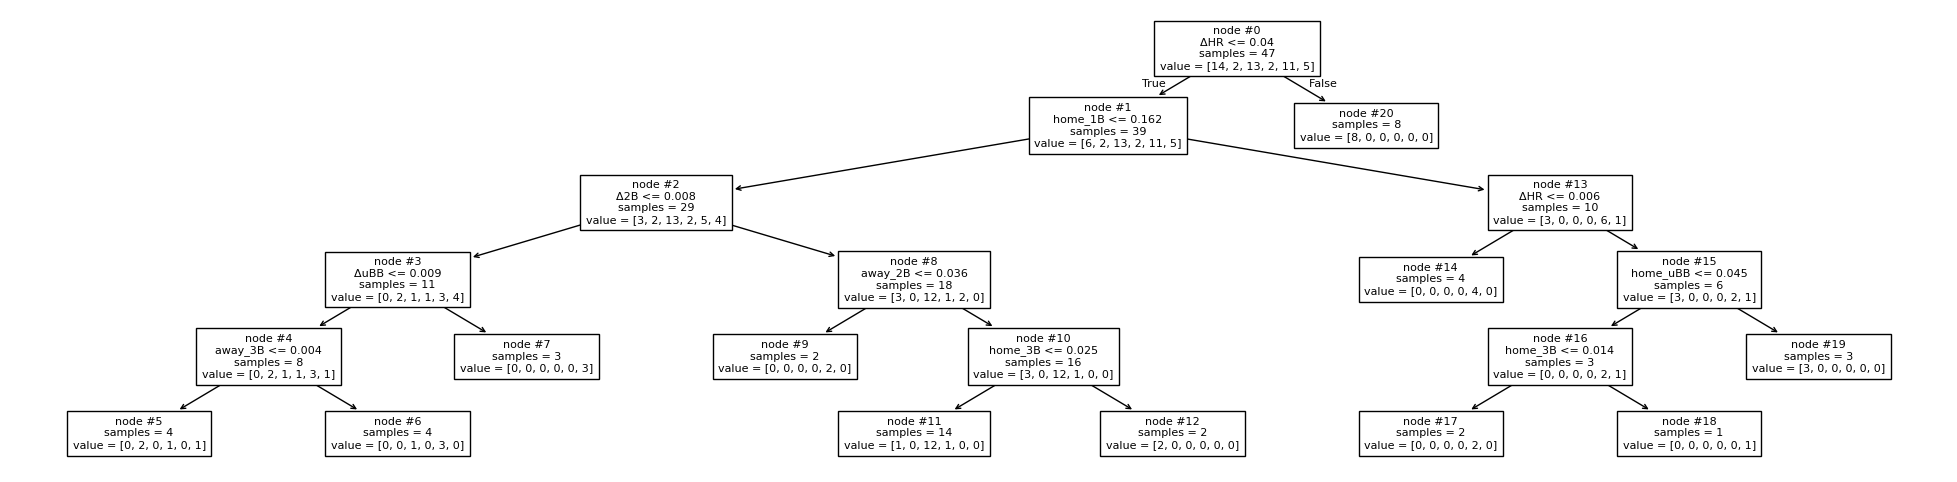

In [127]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
features = ['ΔuBB', 'ΔHBP', 'Δ1B', 'Δ2B', 'Δ3B', 'ΔHR', 'ΔSO',
        'home_uBB', 'home_HBP', 'home_1B', 'home_2B', 'home_3B', 'home_HR', 
        'away_uBB', 'away_HBP', 'away_1B', 'away_2B', 'away_3B', 'away_HR']

X = diffs_df[features]
y = diffs_df['category']

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, random_state=123456)
tree.fit(X, y)
y_pred = tree.predict(X)

acc = accuracy_score(y_pred, y)

print(f"Accuracy: {acc:.3f}")

diffs_df['node'] = tree.apply(X)

def replace_text(obj):
    from matplotlib.text import Annotation
    import re
    if type(obj) == Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj

fig, ax = plt.subplots(figsize=(25, 6))
plot_tree(tree, feature_names=features, node_ids=True, fontsize=8, impurity=False, ax=ax)
# ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
fig.show()

In [128]:
# Reorder
nodes = []
node_wRCs = []
for i in range(1, diffs_df['node'].max()+1):
    node_df = diffs_df.loc[diffs_df['node'] == i]
    if node_df.shape[0] > 0:
        nodes.append(i)
        node_wRCs.append([node_df['ΔwRC+'].mean(), node_df['ΔwRC+'].std()])

nodes = np.array(nodes)
print(nodes.shape)
node_wRCs = np.array(node_wRCs)
sort_inds = np.argsort(node_wRCs[:,0])
node_wRCs = node_wRCs[sort_inds]
new_nodes = np.arange(1, nodes.shape[0]+1)
node_map = {init_node: new_node for init_node, new_node in zip(nodes[sort_inds], new_nodes)}
nodes = new_nodes.copy()
for index, r in diffs_df.iterrows():
    diffs_df['node'].loc[index] = node_map[diffs_df['node'].loc[index]]


(11,)


In [129]:
node_wRCs = []
for i in range(1, diffs_df['node'].max()+1):
    node_df = diffs_df.loc[diffs_df['node'] == i]
    if node_df.shape[0] > 0:
        print('Node', i)
        display(node_df)
        node_wRCs.append([node_df['ΔwRC+'].mean(), node_df['ΔwRC+'].std()])
node_wRCs = np.array(node_wRCs)

Node 1


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Kris Bryant,-21.415570,0.008246,-0.007069,-0.010605,0.039751,-0.011480,0.000000,-0.001717,-0.044728,71.475196,...,-3.238095,23.809524,30.000000,-6.190476,6.250000,0.0,6.250000,34.375000,19.047619,15.327381
Daniel Descalso,-38.885750,-0.010632,0.007217,-0.003000,0.019298,-0.016523,0.026449,-0.044464,-0.033163,52.072000,...,-7.692308,10.714286,42.307692,-31.593407,0.000000,5.0,-5.000000,15.789474,35.000000,-19.210526
Chris Iannetta,-3.854959,0.007489,-0.013284,-0.000662,0.009508,0.002285,0.002437,0.007151,-0.013388,97.946514,...,4.010025,30.952381,36.842105,-5.889724,6.666667,0.0,6.666667,46.666667,35.714286,10.952381
Jose Iglesias,-49.619469,-0.038000,0.000598,0.007950,-0.047067,-0.010277,0.000000,0.010955,-0.060442,61.000000,...,0.000000,21.917808,28.787879,-6.870071,0.000000,0.0,0.000000,27.777778,43.750000,-15.972222


Node 2


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Nolan Jones,-7.391263,0.024811,0.023897,-0.000350,0.048614,-0.030315,-0.005524,-0.011754,-0.118848,103.936170,...,-12.912801,41.818182,51.020408,-9.202226,21.875,15.384615,6.490385,40.625000,30.769231,9.855769
Ben Paulsen,-0.994047,0.045192,0.020564,0.002097,0.031330,0.007980,0.010526,-0.027737,-0.085503,89.601423,...,-10.851927,32.352941,34.482759,-2.129817,5.000,2.941176,2.058824,30.000000,14.705882,15.294118
Alan Trejo,-11.346021,0.030195,0.011078,0.004848,0.008157,-0.012927,0.000000,0.019345,-0.070875,45.335766,...,-2.403846,19.230769,33.333333,-14.102564,0.000,5.000000,-5.000000,19.230769,30.000000,-10.769231


Node 3


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Yonathan Daza,-0.050498,0.045063,-0.003021,0.001765,0.014159,0.013033,0.010924,0.009494,-0.050987,77.547046,...,-0.194484,16.071429,14.851485,1.219943,0.0,0.0,0.0,7.692308,18.918919,-11.226611


Node 4


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Justin Morneau,2.622249,0.048484,-0.021124,0.005912,0.043160,-0.014399,-0.000074,0.034392,-0.080535,118.713896,...,4.273504,38.461538,22.222222,16.239316,0.0,0.0,0.0,54.545455,40.000000,14.545455
Gerardo Parra,0.641995,0.047450,-0.003825,0.000318,0.013451,0.020183,0.000286,0.019052,-0.008242,79.543657,...,-1.482088,18.803419,30.851064,-12.047645,0.0,0.0,0.0,25.714286,20.253165,5.461121


Node 5


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Sam Hilliard,3.687113,0.044020,-0.015078,-0.004768,0.034016,0.041740,0.002748,-0.01378,-0.113447,87.610417,...,-1.683074,43.283582,40.425532,2.858050,10.000000,15.384615,-5.384615,47.500000,42.307692,5.192308
Michael Toglia,3.904123,0.049733,0.020470,-0.003956,0.031672,0.031563,0.012731,-0.04280,-0.057415,74.061538,...,2.554180,54.385965,52.941176,1.444788,11.363636,2.857143,8.506494,40.909091,25.714286,15.194805


Node 6


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Tyler Freeman,5.389381,0.049000,0.010714,-0.013193,-0.010701,0.050428,0.014087,-0.001584,-0.071207,93.000000,...,-2.439024,35.555556,48.780488,-13.224932,8.333333,0.000000,8.333333,41.666667,55.555556,-13.888889
Nick Hundley,9.893886,0.058910,0.012680,-0.004364,0.027840,0.001986,0.016865,0.004824,-0.049853,100.294906,...,2.707750,32.352941,33.333333,-0.980392,5.263158,20.000000,-14.736842,26.315789,40.000000,-13.684211
DJ LeMahieu,10.693334,0.063560,0.014718,-0.001397,0.030357,0.019942,0.010412,-0.010118,-0.036139,96.228070,...,-1.917827,36.042403,36.470588,-0.428185,4.123711,1.265823,2.857889,34.020619,41.772152,-7.751533
Daniel Murphy,3.241350,0.049259,-0.007850,0.004586,0.065484,0.027336,0.005159,-0.046216,-0.102065,80.637224,...,-2.083333,19.696970,25.000000,-5.303030,2.941176,0.000000,2.941176,38.235294,17.647059,20.588235


Node 7


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
David Dahl,23.645610,0.079043,-0.001221,-0.000676,0.039109,-0.002978,0.009310,0.037520,-0.075236,112.289617,...,0.324915,31.531532,27.868852,3.662679,5.172414,2.380952,2.791461,18.965517,16.666667,2.298851
Garrett Hampson,2.867939,0.052298,-0.018115,0.001407,0.041782,0.004130,0.020003,0.004035,-0.058777,68.611842,...,-0.660699,20.652174,21.568627,-0.916454,0.000000,9.677419,-9.677419,11.627907,25.806452,-14.178545
Ryan McMahon,10.293284,0.056610,0.002035,0.001229,0.012967,0.007808,0.000570,0.033787,-0.019890,94.140914,...,0.703463,42.532468,46.590909,-4.058442,7.936508,8.024691,-0.088183,42.328042,33.333333,8.994709
Ezequiel Tovar,11.294470,0.058899,0.006876,-0.000776,0.048738,-0.000263,0.011487,-0.006312,-0.005989,89.082081,...,-5.752711,29.577465,37.991266,-8.413802,7.407407,6.451613,0.955795,40.740741,32.258065,8.482676


Node 8


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Nolan Arenado,21.792415,0.074799,-0.000341,0.000569,0.015456,0.017703,0.010616,0.032335,-0.026261,128.379939,...,-1.015595,29.919137,31.122449,-1.203312,6.666667,8.695652,-2.028986,45.000000,33.043478,11.956522
Jordan Beck,14.395760,0.066606,-0.009942,-0.002139,0.061872,0.033203,0.003610,-0.019340,-0.087938,84.717884,...,-7.405797,31.521739,25.333333,6.188406,16.666667,13.636364,3.030303,16.666667,22.727273,-6.060606
Ian Desmond,-16.382668,0.017708,0.010201,-0.003940,0.006925,0.018884,0.006582,-0.020218,-0.033351,73.635995,...,-6.779388,34.057971,44.444444,-10.386473,7.317073,10.638298,-3.321225,24.390244,34.042553,-9.652309
Elias Díaz,12.662696,0.062208,-0.003512,0.000205,0.015987,0.025434,0.000184,0.025186,-0.051470,88.187726,...,0.688147,35.436893,32.417582,3.019311,6.024096,3.571429,2.452668,26.506024,27.380952,-0.874928
Brenton Doyle,26.813551,0.085233,0.001213,0.002791,0.020323,0.024786,0.010459,0.027385,-0.041361,87.718670,...,2.941176,28.823529,41.176471,-12.352941,5.882353,6.250000,-0.367647,23.529412,34.375000,-10.845588
Hunter Goodman,17.469344,0.067309,0.013076,0.001221,0.028356,0.010142,-0.001072,0.016075,-0.047170,105.662281,...,-0.198789,38.655462,45.161290,-6.505828,9.375000,10.344828,-0.969828,40.625000,31.034483,9.590517
Randal Grichuk,19.770114,0.061874,-0.011475,-0.006185,0.026258,0.011626,0.009228,0.033647,-0.053622,105.121387,...,0.074906,33.707865,38.666667,-4.958801,16.666667,6.451613,10.215054,50.000000,35.483871,14.516129
Matt Holliday,32.462699,0.052210,0.004487,0.002689,0.001699,0.013290,0.002327,0.029121,-0.021013,149.586121,...,22.222222,44.444444,57.142857,-12.698413,0.000000,NaN,NaN,50.000000,NaN,NaN
Connor Joe,12.406062,0.057803,0.012937,0.005134,-0.007657,0.030763,0.019938,-0.002361,-0.012709,104.123077,...,-3.609626,27.272727,29.411765,-2.139037,8.000000,3.846154,4.153846,32.000000,15.384615,16.615385
Jurickson Profar,12.548673,0.062000,0.000617,0.006994,0.004058,0.055519,0.013613,-0.018210,-0.055724,86.000000,...,-4.646465,20.000000,36.363636,-16.363636,3.448276,5.263158,-1.814882,24.137931,42.105263,-17.967332


Node 9


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Charlie Blackmon,28.670357,0.085868,0.007457,0.000994,0.031516,0.004488,0.019726,0.023753,-0.040173,123.703414,...,-0.146199,31.189084,32.236842,-1.047758,6.333333,4.304636,2.028698,37.666667,30.132450,7.534216
Brendan Rodgers,27.360964,0.084336,0.014006,0.003223,0.038482,0.028436,-0.007024,0.007406,-0.031828,101.794505,...,0.349744,39.086294,34.928230,4.158065,7.142857,3.125000,4.017857,44.047619,26.562500,17.485119
Raimel Tapia,28.502180,0.092524,0.013692,-0.003045,0.022849,0.026978,0.013738,0.020788,-0.059019,93.978962,...,3.338085,31.884058,22.131148,9.752910,2.666667,0.000000,2.666667,29.333333,30.666667,-1.333333


Node 10


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Brandon Barnes,39.470575,0.11464,0.014167,0.003970,0.026409,0.018687,0.017864,0.035055,-0.093535,89.322222,...,-2.857143,32.075472,11.428571,20.646900,7.692308,0.0,7.692308,23.076923,0.0,23.076923
Mickey Moniak,45.044248,0.10700,0.021168,-0.000604,0.010867,0.033921,0.008777,0.034135,-0.037393,130.000000,...,8.472401,47.368421,43.902439,3.465982,18.421053,8.0,10.421053,42.105263,36.0,6.105263


Node 11


,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
C.J. Cron,40.956933,0.102694,-0.004256,0.000106,0.013492,0.023423,0.004522,0.067729,-0.019802,129.145805,...,8.643617,38.297872,27.083333,11.214539,17.647059,10.526316,7.120743,43.137255,33.333333,9.803922
Corey Dickerson,74.679977,0.159146,0.023512,0.001644,0.018719,0.023994,0.041009,0.049443,-0.089384,165.002262,...,-0.543478,37.500000,65.217391,-27.717391,22.222222,10.526316,11.695906,44.444444,42.105263,2.339181
Joshua Fuentes,58.518774,0.147515,-0.001783,-0.003396,0.064979,0.047352,-0.007642,0.052457,-0.039171,87.121212,...,-0.432744,25.423729,21.276596,4.147133,8.695652,0.000000,8.695652,34.782609,12.500000,22.282609
Carlos González,39.018914,0.101935,0.008246,0.001370,0.018550,0.022261,0.012007,0.040632,-0.057242,135.320343,...,3.238149,42.690058,47.872340,-5.182282,8.602151,8.870968,-0.268817,38.709677,33.064516,5.645161
Elehuris Montero,39.913494,0.107770,0.019999,-0.003976,0.041859,0.005944,-0.004473,0.050345,-0.098884,90.857527,...,-1.911996,41.304348,30.120482,11.183866,4.000000,0.000000,4.000000,32.000000,18.181818,13.818182
Mark Reynolds,34.424178,0.093236,0.018663,0.001027,0.021701,0.002005,0.002272,0.050342,-0.035190,116.653576,...,4.859568,26.732673,28.571429,-1.838755,6.666667,6.451613,0.215054,30.000000,16.129032,13.870968
Drew Stubbs,98.854396,0.199192,-0.008680,-0.000185,0.073429,0.050446,-0.001250,0.085036,-0.147232,151.034130,...,50.000000,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000,100.000000,50.000000,50.000000
Pat Valaika,34.435737,0.107011,-0.007974,0.000000,0.021237,0.038875,0.007788,0.053260,-0.075468,76.799043,...,5.871212,27.083333,13.636364,13.446970,0.000000,0.000000,0.000000,23.529412,11.764706,11.764706


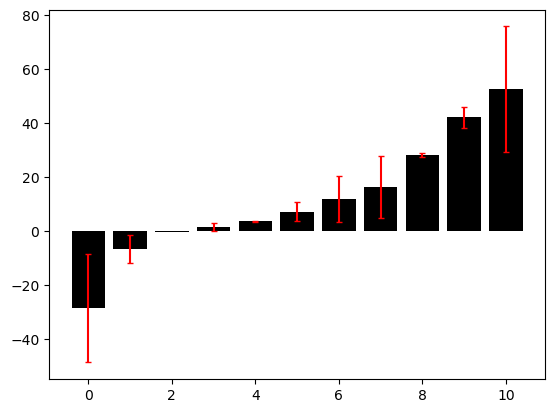

In [131]:
plt.bar(np.arange(nodes.shape[0]), node_wRCs[:,0], color='k')
plt.errorbar(np.arange(nodes.shape[0]), node_wRCs[:,0], node_wRCs[:,1], color='r', capsize=2, fmt='none')
plt.show()

## Load batted balls

In [132]:
from utils.scraping.savant import load_batted_ball_data
batted_ball_data = load_batted_ball_data(2015,2025)

## Batted ball methods

In [133]:
# Define pitch types
fastballs = ['FA', 'FF', 'SI', 'FC']
breaking_balls = ['CU', 'KC', 'SL', 'ST', 'SV']
changeups = ['CH']

pitch_groups = [fastballs, breaking_balls, changeups]
pitch_names = ['FB', 'BR', 'CH']

In [134]:
# def savant_to_field_xy(hc_x, hc_y):
#     # Recenter at home plate
#     x = hc_x - 125.0
#     y = 199.0 - hc_y   # flip y-axis

#     # Scale pixels → feet
#     scale = 2.5
#     return x * scale, y * scale


## Additional splits

In [135]:
additional_metrics = [
    # All pitches (aggregate)
    'home_barrel_perc',
    'away_barrel_perc',
    'Δbarrel_perc',
    'home_hardhit_perc',
    'away_hardhit_perc',
    'Δhardhit_perc',

    # Fastballs
    'home_FB_barrel_perc',
    'away_FB_barrel_perc',
    'ΔFB_barrel_perc',
    'home_FB_hardhit_perc',
    'away_FB_hardhit_perc',
    'ΔFB_hardhit_perc',

    # Breaking balls
    'home_BR_barrel_perc',
    'away_BR_barrel_perc',
    'ΔBR_barrel_perc',
    'home_BR_hardhit_perc',
    'away_BR_hardhit_perc',
    'ΔBR_hardhit_perc',

    # Changeups
    'home_CH_barrel_perc',
    'away_CH_barrel_perc',
    'ΔCH_barrel_perc',
    'home_CH_hardhit_perc',
    'away_CH_hardhit_perc',
    'ΔCH_hardhit_perc',
]


for metric in additional_metrics:
    diffs_df[metric] = np.zeros(diffs_df.shape[0])

diffs_df.head()

,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Nolan Arenado,21.792415,0.074799,-0.000341,0.000569,0.015456,0.017703,0.010616,0.032335,-0.026261,128.379939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brandon Barnes,39.470575,0.114640,0.014167,0.003970,0.026409,0.018687,0.017864,0.035055,-0.093535,89.322222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jordan Beck,14.395760,0.066606,-0.009942,-0.002139,0.061872,0.033203,0.003610,-0.019340,-0.087938,84.717884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Charlie Blackmon,28.670357,0.085868,0.007457,0.000994,0.031516,0.004488,0.019726,0.023753,-0.040173,123.703414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kris Bryant,-21.415570,0.008246,-0.007069,-0.010605,0.039751,-0.011480,0.000000,-0.001717,-0.044728,71.475196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# Iterate through players
for player in diffs_df.index.to_list():

    # Get name
    first, last = player.split()
    if first == 'C.J.':
        first = 'CJ'

    """
    ALL PITCHES
    """
    # Get dataframes
    home_df = filter_df(batted_ball_data, last=last, first=first, batter=True, home_team='COL', batter_on_team='COL')
    away_df = filter_df(batted_ball_data, last=last, first=first, batter=True, away_team='COL', batter_on_team='COL')

    # Get hard hit rates
    home_hardhit_perc = get_hard_hit_rate(home_df)
    diffs_df['home_hardhit_perc'].loc[player] = home_hardhit_perc
    away_hardhit_perc = get_hard_hit_rate(away_df)
    diffs_df['away_hardhit_perc'].loc[player] = away_hardhit_perc
    diffs_df['Δhardhit_perc'].loc[player] = home_hardhit_perc - away_hardhit_perc

    # Get barrel rates
    home_barrel_perc = get_barrel_rate(home_df)
    diffs_df['home_barrel_perc'].loc[player] = home_barrel_perc
    away_barrel_perc = get_barrel_rate(away_df)
    diffs_df['away_barrel_perc'].loc[player] = away_barrel_perc
    diffs_df['Δbarrel_perc'].loc[player] = home_barrel_perc - away_barrel_perc

    """
    CERTAIN PITCH TYPES
    """
    for pitch_types, pitch_types_key in zip(pitch_groups, pitch_names):

        # Get dataframes
        home_df = filter_df(batted_ball_data, last=last, first=first, batter=True, home_team='COL', batter_on_team='COL', pitch_type=pitch_types)
        away_df = filter_df(batted_ball_data, last=last, first=first, batter=True, away_team='COL', batter_on_team='COL', pitch_type=pitch_types)
    
        # Get hard hit rates
        home_hardhit_perc = get_hard_hit_rate(home_df)
        diffs_df[f'home_{pitch_types_key}_hardhit_perc'].loc[player] = home_hardhit_perc
        away_hardhit_perc = get_hard_hit_rate(away_df)
        diffs_df[f'away_{pitch_types_key}_hardhit_perc'].loc[player] = away_hardhit_perc
        diffs_df[f'Δ{pitch_types_key}_hardhit_perc'].loc[player] = home_hardhit_perc - away_hardhit_perc
    
        # Get barrel rates
        home_barrel_perc = get_barrel_rate(home_df)
        diffs_df[f'home_{pitch_types_key}_barrel_perc'].loc[player] = home_barrel_perc
        away_barrel_perc = get_barrel_rate(away_df)
        diffs_df[f'away_{pitch_types_key}_barrel_perc'].loc[player] = away_barrel_perc
        diffs_df[f'Δ{pitch_types_key}_barrel_perc'].loc[player] = home_barrel_perc - away_barrel_perc

In [137]:
diffs_df.head()

,ΔwRC+,ΔwOBA,ΔuBB,ΔHBP,Δ1B,Δ2B,Δ3B,ΔHR,ΔSO,home_wRC+,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Nolan Arenado,21.792415,0.074799,-0.000341,0.000569,0.015456,0.017703,0.010616,0.032335,-0.026261,128.379939,...,-1.015595,29.919137,31.122449,-1.203312,6.666667,8.695652,-2.028986,45.000000,33.043478,11.956522
Brandon Barnes,39.470575,0.114640,0.014167,0.003970,0.026409,0.018687,0.017864,0.035055,-0.093535,89.322222,...,-2.857143,32.075472,11.428571,20.646900,7.692308,0.000000,7.692308,23.076923,0.000000,23.076923
Jordan Beck,14.395760,0.066606,-0.009942,-0.002139,0.061872,0.033203,0.003610,-0.019340,-0.087938,84.717884,...,-7.405797,31.521739,25.333333,6.188406,16.666667,13.636364,3.030303,16.666667,22.727273,-6.060606
Charlie Blackmon,28.670357,0.085868,0.007457,0.000994,0.031516,0.004488,0.019726,0.023753,-0.040173,123.703414,...,-0.146199,31.189084,32.236842,-1.047758,6.333333,4.304636,2.028698,37.666667,30.132450,7.534216
Kris Bryant,-21.415570,0.008246,-0.007069,-0.010605,0.039751,-0.011480,0.000000,-0.001717,-0.044728,71.475196,...,-3.238095,23.809524,30.000000,-6.190476,6.250000,0.000000,6.250000,34.375000,19.047619,15.327381


## Build a multinomial logisitic regression model to predict leaf identify

In [138]:
from sklearn.linear_model import LogisticRegression

# Curate date
X = diffs_df[additional_metrics].fillna(0)
y = diffs_df['node']

# Build model
model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=1,             # smaller = stronger regularization
        max_iter=10000000,
        n_jobs=-1
)

model.fit(X, y)
y_pred = model.predict(X)
print(f'Accuracy {accuracy_score(y_pred, y):.3f}')

Accuracy 0.957


In [139]:
coefs = pd.DataFrame(
    model.coef_,
    columns=X.columns,
    index=[f'Leaf_{i}' for i in model.classes_]
)
coefs.head()

,home_barrel_perc,away_barrel_perc,Δbarrel_perc,home_hardhit_perc,away_hardhit_perc,Δhardhit_perc,home_FB_barrel_perc,away_FB_barrel_perc,ΔFB_barrel_perc,home_FB_hardhit_perc,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Leaf_1,0.000000,0.000000,0.0,0.000000,0.044284,0.0,0.058011,0.157394,0.000000,0.000000,...,0.000000,-0.360211,0.000000,-0.118805,-0.017737,-0.437864,0.156363,0.086351,0.256317,0.000000
Leaf_2,0.000000,0.000000,0.0,-0.009108,0.000000,0.0,0.000000,-0.136041,0.278973,-0.010787,...,-0.473534,0.000000,0.061407,-0.022250,0.000000,0.000000,-0.088354,-0.050585,0.000000,0.000000
Leaf_3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.165637,...,0.000000,0.000000,-0.106030,0.000000,0.000000,-0.120138,0.000000,-0.174290,0.000000,-0.272845
Leaf_4,-0.023659,0.000000,0.0,0.039703,0.000000,0.0,0.000000,0.000000,0.000000,0.084266,...,0.000000,-0.274028,-0.026803,0.000000,-0.353124,-0.222852,0.000000,0.137414,0.102395,0.000000
Leaf_5,0.000000,0.159906,0.0,0.000000,0.000000,0.0,0.101158,0.273989,0.000000,-0.198187,...,0.000000,0.318926,0.000000,0.168277,0.000000,0.000000,-0.104860,0.000000,-0.055702,0.000000


In [140]:
mask_inside = (coefs > -0.2) & (coefs < 0.2)
coefs = coefs.mask(mask_inside, other=0)
coefs.head()

,home_barrel_perc,away_barrel_perc,Δbarrel_perc,home_hardhit_perc,away_hardhit_perc,Δhardhit_perc,home_FB_barrel_perc,away_FB_barrel_perc,ΔFB_barrel_perc,home_FB_hardhit_perc,...,ΔBR_barrel_perc,home_BR_hardhit_perc,away_BR_hardhit_perc,ΔBR_hardhit_perc,home_CH_barrel_perc,away_CH_barrel_perc,ΔCH_barrel_perc,home_CH_hardhit_perc,away_CH_hardhit_perc,ΔCH_hardhit_perc
Leaf_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,-0.360211,0.0,0.0,0.000000,-0.437864,0.0,0.0,0.256317,0.000000
Leaf_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.278973,0.0,...,-0.473534,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Leaf_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,-0.272845
Leaf_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,-0.274028,0.0,0.0,-0.353124,-0.222852,0.0,0.0,0.000000,0.000000
Leaf_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273989,0.000000,0.0,...,0.000000,0.318926,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


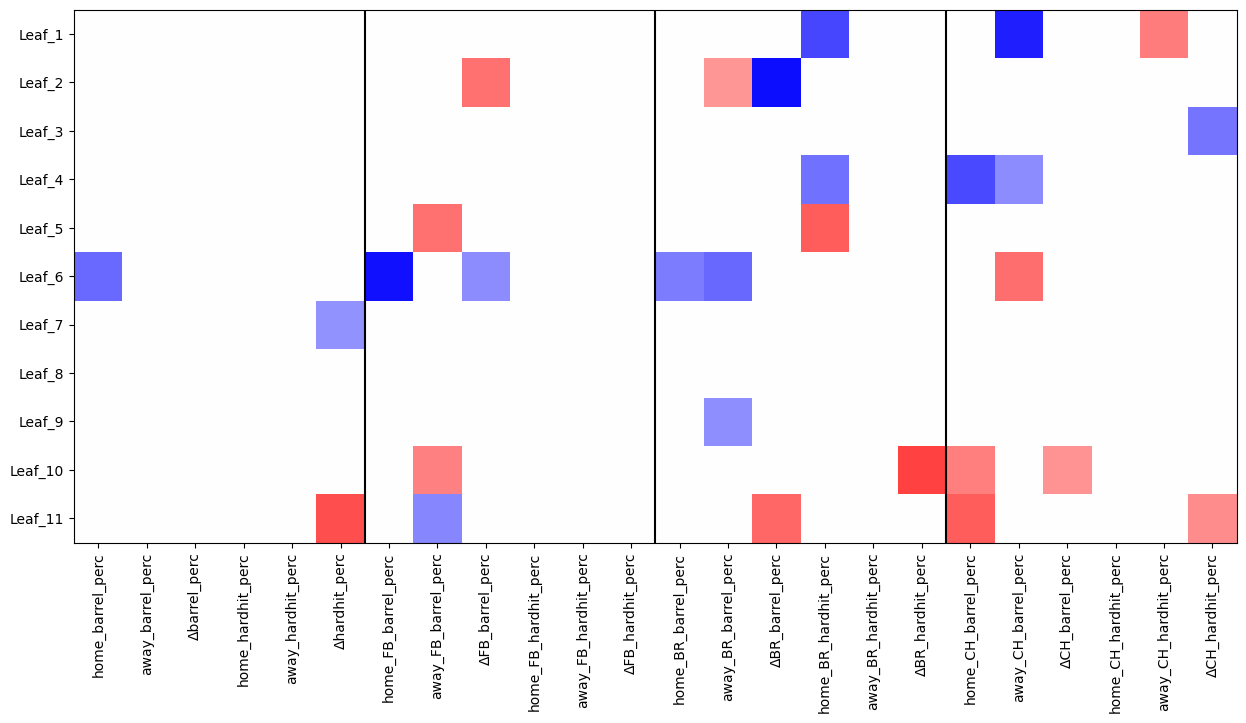

In [157]:
fig = plt.figure(figsize=(15, 8))
plt.imshow(coefs, vmax=0.5, vmin=-0.5, cmap='bwr')
plt.yticks(np.arange(coefs.shape[0]), coefs.index.to_list())
plt.xticks(np.arange(coefs.shape[1]), coefs.columns.to_list(), rotation=90)
plt.vlines(5.5, -0.5, 10.5, color='k')
plt.vlines(11.5, -0.5, 10.5, color='k')
plt.vlines(17.5, -0.5, 10.5, color='k')

plt.show()

In [142]:
for i in range(1, diffs_df['node'].max()+1):
    node_df = diffs_df.loc[diffs_df['node'] == i]
    if node_df.shape[0] > 0:
        print('Node', i)
        display(node_df[['ΔwRC+', 'ΔwOBA', 'category']])

Node 1


,ΔwRC+,ΔwOBA,category
Kris Bryant,-21.415570,0.008246,med_inverse
Daniel Descalso,-38.885750,-0.010632,large_inverse
Chris Iannetta,-3.854959,0.007489,small_inverse
Jose Iglesias,-49.619469,-0.038000,large_inverse


Node 2


,ΔwRC+,ΔwOBA,category
Nolan Jones,-7.391263,0.024811,small_inverse
Ben Paulsen,-0.994047,0.045192,small_inverse
Alan Trejo,-11.346021,0.030195,small_inverse


Node 3


,ΔwRC+,ΔwOBA,category
Yonathan Daza,-0.050498,0.045063,small_inverse


Node 4


,ΔwRC+,ΔwOBA,category
Justin Morneau,2.622249,0.048484,small
Gerardo Parra,0.641995,0.047450,small


Node 5


,ΔwRC+,ΔwOBA,category
Sam Hilliard,3.687113,0.044020,small
Michael Toglia,3.904123,0.049733,small


Node 6


,ΔwRC+,ΔwOBA,category
Tyler Freeman,5.389381,0.049000,small
Nick Hundley,9.893886,0.058910,small
DJ LeMahieu,10.693334,0.063560,small
Daniel Murphy,3.241350,0.049259,small


Node 7


,ΔwRC+,ΔwOBA,category
David Dahl,23.645610,0.079043,med
Garrett Hampson,2.867939,0.052298,small
Ryan McMahon,10.293284,0.056610,small
Ezequiel Tovar,11.294470,0.058899,small


Node 8


,ΔwRC+,ΔwOBA,category
Nolan Arenado,21.792415,0.074799,med
Jordan Beck,14.395760,0.066606,med
Ian Desmond,-16.382668,0.017708,med_inverse
Elias Díaz,12.662696,0.062208,med
Brenton Doyle,26.813551,0.085233,med
Hunter Goodman,17.469344,0.067309,med
Randal Grichuk,19.770114,0.061874,med
Matt Holliday,32.462699,0.052210,large
Connor Joe,12.406062,0.057803,med
Jurickson Profar,12.548673,0.062000,med


Node 9


,ΔwRC+,ΔwOBA,category
Charlie Blackmon,28.670357,0.085868,large
Brendan Rodgers,27.360964,0.084336,large
Raimel Tapia,28.502180,0.092524,large


Node 10


,ΔwRC+,ΔwOBA,category
Brandon Barnes,39.470575,0.11464,large
Mickey Moniak,45.044248,0.10700,large


Node 11


,ΔwRC+,ΔwOBA,category
C.J. Cron,40.956933,0.102694,large
Corey Dickerson,74.679977,0.159146,large
Joshua Fuentes,58.518774,0.147515,large
Carlos González,39.018914,0.101935,large
Elehuris Montero,39.913494,0.107770,large
Mark Reynolds,34.424178,0.093236,large
Drew Stubbs,98.854396,0.199192,large
Pat Valaika,34.435737,0.107011,large
